In [12]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [13]:
folder = '../../results/'

figs = os.path.join(folder, 'figs')
file = os.path.join(folder, 'summarized-results.csv')

df = pd.read_csv(file)

categories = ['INVO', 'LOOP', 'FORK', 'RETU', 'FINA']


### Generate Cliffs-Delta Table

In [14]:
def analyze_tests(bench):
    # Simply check whether there is an instance where Wilcoxon test showed
    # significant difference
    impacted = bench.query('Wilcoxom==True')
    # print(impacted["Cliffs Delta d"])
    non_negligible = impacted[(impacted["Cliffs Delta d"] >= 0.14) | (impacted["Cliffs Delta d"] <= -0.14)]
    # print(len(non_negligible))
    return pd.Series({'Test Impacted': len(non_negligible) > 0, 
                      'Highest Cliff': impacted['Cliffs Delta d'].max(), 
                      'Median Cliff': impacted['Cliffs Delta d'].median()})
    

def analyze_project(proj):
        
    instances_total = len(proj)
    instances_not_impacted = len(proj.query('Wilcoxom==False'))
    instances_impacted = len(proj.query('Wilcoxom==True'))
    instances_deltas = proj.query('Wilcoxom==True')['Cliffs Delta Size'].value_counts()
    
    if 'negligible' not in instances_deltas:
        instances_deltas['negligible'] = 0
    if 'medium' not in instances_deltas:
        instances_deltas['medium'] = 0
    
    
    tests = proj.groupby(['Class', 'Method']).apply(analyze_tests)
    tests_impacted = len(tests[tests['Test Impacted'] == True])
    tests_total = len(tests)
    large = len(tests[tests['Highest Cliff'].abs() > 0.47])
    medium = len(tests[(tests['Highest Cliff'].abs() > 0.33) & (tests['Highest Cliff'].abs() < 0.47)])
    small = len(tests[(tests['Highest Cliff'].abs() > 0.147) & (tests['Highest Cliff'].abs() < 0.33)])
    negligible = len(tests[tests['Highest Cliff'].abs() < 0.147])
    
    result = {'Tests Impacted': '%d/%d' % (tests_impacted, tests_total),
              'Tests Impacted %': tests_impacted / tests_total * 100.0, 
              'Tests Large': large,
              'Tests Medium': medium,
              'Tests Small': small,
              'Tests Neglig': negligible,
              'Instances Impacted': '%d/%d' % (instances_impacted, instances_total),
              'Instances Impacted %': instances_impacted / instances_total * 100.0}
    # Cliff-deltas
    result.update(instances_deltas)
    return pd.Series(data=result)
       
pd.options.display.float_format = '{:,.1f}'.format    

column_order = ['Tests Impacted', 'Tests Impacted %',  'Instances Impacted', 'Instances Impacted %',
                'negligible', 'small', 'medium', 'large']
column_order = ['Tests Impacted', 'Tests Impacted %',  'Tests Large', 'Tests Medium',
                'Tests Small', 'Tests Neglig']

def print_table(df, category):
    
    df_cat = df.query('Experiment == @category')    
    table = df_cat.groupby(by='Project').apply(analyze_project)
    
    table = table.replace({'negligible': 'N', 
                           'small': 'S',
                           'medium': 'M',
                           'large': 'L'})

    table = table.unstack(1)
    table = table.fillna('')
    #table.loc['Total'] = table.sum()
    
    print(table[column_order].to_latex())


In [15]:
print_table(df, 'INVO')

\begin{tabular}{llrrrrr}
\toprule
{} & Tests Impacted &  Tests Impacted \% &  Tests Large &  Tests Medium &  Tests Small &  Tests Neglig \\
Project &                &                   &              &               &              &               \\
\midrule
druid   &            2/3 &              66.7 &            2 &             0 &            0 &             0 \\
h2o-3   &            6/6 &             100.0 &            2 &             2 &            2 &             0 \\
netty   &          16/16 &             100.0 &           15 &             1 &            0 &             0 \\
\bottomrule
\end{tabular}



In [16]:
print_table(df, 'LOOP')

\begin{tabular}{llrrrrr}
\toprule
{} & Tests Impacted &  Tests Impacted \% &  Tests Large &  Tests Medium &  Tests Small &  Tests Neglig \\
Project &                &                   &              &               &              &               \\
\midrule
druid   &            6/8 &              75.0 &            5 &             1 &            0 &             0 \\
log4j2  &            7/7 &             100.0 &            4 &             2 &            1 &             0 \\
netty   &          10/10 &             100.0 &           10 &             0 &            0 &             0 \\
\bottomrule
\end{tabular}



In [17]:
print_table(df, 'FORK')

\begin{tabular}{lll}
\toprule
             &       &     0 \\
{} & Project &       \\
\midrule
Tests Impacted & pgdbc &   5/5 \\
Tests Impacted \% & pgdbc & 100.0 \\
Tests Large & pgdbc &     5 \\
Tests Medium & pgdbc &     0 \\
Tests Small & pgdbc &     0 \\
Tests Neglig & pgdbc &     0 \\
\bottomrule
\end{tabular}



In [18]:
print_table(df, 'RETU')

\begin{tabular}{llrrrrr}
\toprule
{} & Tests Impacted &  Tests Impacted \% &  Tests Large &  Tests Medium &  Tests Small &  Tests Neglig \\
Project        &                &                   &              &               &              &               \\
\midrule
gs-collections &           9/37 &              24.3 &            8 &             1 &            0 &             0 \\
log4j2         &            5/5 &             100.0 &            4 &             0 &            1 &             0 \\
netty          &            1/1 &             100.0 &            1 &             0 &            0 &             0 \\
\bottomrule
\end{tabular}



In [19]:
print_table(df, 'FINA')

\begin{tabular}{llrrrrr}
\toprule
{} & Tests Impacted &  Tests Impacted \% &  Tests Large &  Tests Medium &  Tests Small &  Tests Neglig \\
Project &                &                   &              &               &              &               \\
\midrule
log4j2  &            4/5 &              80.0 &            0 &             0 &            4 &             0 \\
netty   &            1/2 &              50.0 &            1 &             0 &            0 &             0 \\
\bottomrule
\end{tabular}



### Plot the Clifs-Delta D values

In [20]:
colors = sns.color_palette('coolwarm', 11)

colors = [(0.32860444731764704, 0.43971182997647057, 0.8695872625411765),
 (0.4358148063058824, 0.5707073031529412, 0.951717381282353),
 (0.5543118699137254, 0.6900970112156862, 0.9955155482352941),
 (0.6672529243333334, 0.7791764569999999, 0.992959213),
 (0.7727059486039215, 0.8389782172392156, 0.9493187599137255),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079),
 (0.9383263563333333, 0.8089165520313726, 0.741161515027451),
 (0.968203399, 0.7208441, 0.6122929913333334),
 (0.9566532109764706, 0.598033822717647, 0.4773022923529412),
 (0.9057834780117647, 0.4551856921647059, 0.35533588384705883),
 (0.8204010983882353, 0.2867649126352941, 0.2451595198)]


In [21]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})



def normalize_d(df):
    
    if df['Benchmark Mode'] == 'Throughput, ops/time':
        return df['Cliffs Delta d']
    else:
        return df['Cliffs Delta d'] * -1

def plot_dsizes(df, category):

    bins=np.array([-10,-8,-6,-4,-2,-1.4,0,1.4,2,4,6,8,10])
    bins = bins/10
    
    print(bins)
       
    df['Cliffs Delta d norm'] = df.apply(normalize_d, axis=1)
    binned_df = pd.cut(df['Cliffs Delta d norm'], bins=bins, precision=1).value_counts()
    # Sort first
    binned_df = binned_df.sort_index()
    print(binned_df)
    
    x_ticks = ['%.1f' % x for x in bins]
    print(x_ticks)
    
    fig = plt.figure(figsize=(7,3.5))
    plt.xticks(fontsize=11)
    
    ax = sns.barplot(x=binned_df.index, y=binned_df, palette=colors)
    ax.set(xlabel="Cliff's delta", ylabel='# Benchmark Instances')
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_ticks))

    plt.tight_layout()
    #plt.savefig(os.path.join(figs, 'distribution-deltas-%s.pdf' % category))
    

[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]     1
(-0.8, -0.6]     1
(-0.6, -0.4]     1
(-0.4, -0.2]     1
(-0.2, -0.1]     0
(-0.1, 0.0]      5
(0.0, 0.1]       0
(0.1, 0.2]       0
(0.2, 0.4]       7
(0.4, 0.6]       5
(0.6, 0.8]       5
(0.8, 1.0]      56
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


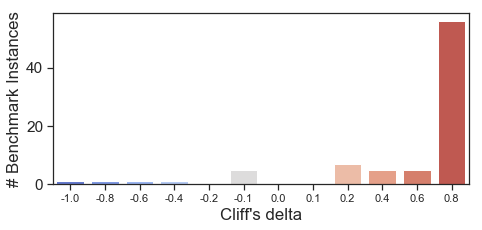

In [22]:
loop = df_cat = df.query('Experiment == "LOOP"')

plot_dsizes(loop, 'LOOP')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24
128
[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    15
(-0.8, -0.6]     3
(-0.6, -0.4]     2
(-0.4, -0.2]     1
(-0.2, -0.1]     0
(-0.1, 0.0]      0
(0.0, 0.1]       1
(0.1, 0.2]       0
(0.2, 0.4]       0
(0.4, 0.6]       0
(0.6, 0.8]       0
(0.8, 1.0]       1
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']
[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    18
(-0.8, -0.6]     2
(-0.6, -0.4]     3
(-0.4, -0.2]     5
(-0.2, -0.1]     3
(-0.1, 0.0]     18
(0.0, 0.1]      23
(0.1, 0.2]       4
(0.2, 0.4]      15
(0.4, 0.6]       2
(0.6, 0.8]       1
(0.8, 1.0]       1
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


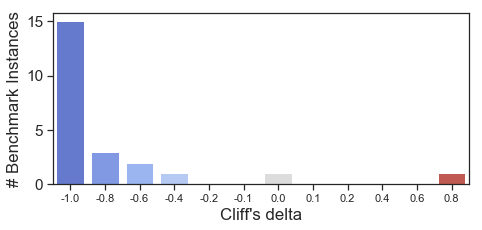

C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


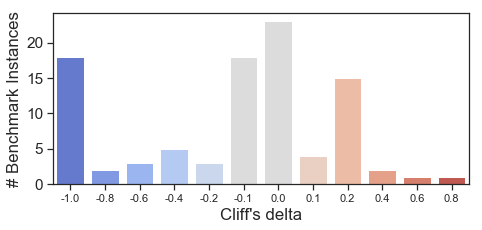

In [23]:
affected = ['httpAddAllFast', 'http2AddAllFastest', 'http2AddAllFast', 'http2AddAllSlow'] 
directly_affected = df.query('Method in @affected and Experiment == "INVO"')
not_directly_affected = df.query('Method not in @affected and Experiment == "INVO"')

print(len(directly_affected))
print(len(not_directly_affected))

plot_dsizes(directly_affected, 'INVO-directly')
plot_dsizes(not_directly_affected, 'INVO-indirectly')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    5
(-0.8, -0.6]    0
(-0.6, -0.4]    0
(-0.4, -0.2]    0
(-0.2, -0.1]    0
(-0.1, 0.0]     0
(0.0, 0.1]      0
(0.1, 0.2]      0
(0.2, 0.4]      0
(0.4, 0.6]      0
(0.6, 0.8]      0
(0.8, 1.0]      1
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


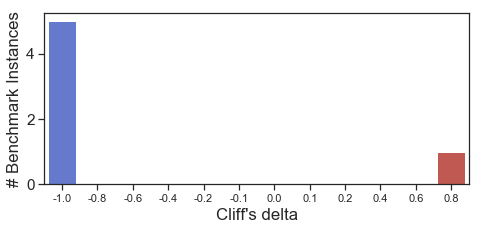

In [24]:
affected = ['httpAddAllFast'] 

httpaddallfast = df.query('Method in @affected and Experiment == "INVO"')

plot_dsizes(httpaddallfast, 'httpaddallfast')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    5
(-0.8, -0.6]    0
(-0.6, -0.4]    0
(-0.4, -0.2]    0
(-0.2, -0.1]    0
(-0.1, 0.0]     0
(0.0, 0.1]      0
(0.1, 0.2]      0
(0.2, 0.4]      0
(0.4, 0.6]      0
(0.6, 0.8]      0
(0.8, 1.0]      1
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


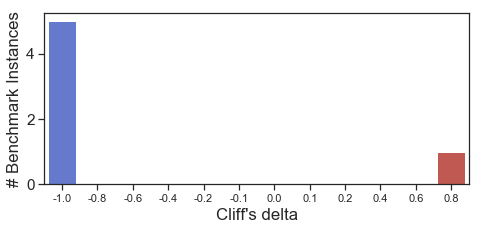

In [25]:
affected = ['httpAddAllFast'] 
httpaddallfast = df.query('Method in @affected and Experiment == "INVO"')

plot_dsizes(httpaddallfast, 'httpaddallfast')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    5
(-0.8, -0.6]    0
(-0.6, -0.4]    0
(-0.4, -0.2]    0
(-0.2, -0.1]    0
(-0.1, 0.0]     0
(0.0, 0.1]      0
(0.1, 0.2]      0
(0.2, 0.4]      0
(0.4, 0.6]      0
(0.6, 0.8]      0
(0.8, 1.0]      1
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


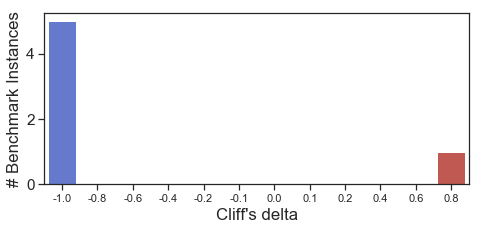

In [26]:
affected = ['httpAddAllFast'] 
httpaddallfast = df.query('Method in @affected and Experiment == "INVO"')

plot_dsizes(httpaddallfast, 'httpaddallfast')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    0
(-0.8, -0.6]    0
(-0.6, -0.4]    0
(-0.4, -0.2]    0
(-0.2, -0.1]    0
(-0.1, 0.0]     0
(0.0, 0.1]      0
(0.1, 0.2]      0
(0.2, 0.4]      0
(0.4, 0.6]      0
(0.6, 0.8]      0
(0.8, 1.0]      9
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


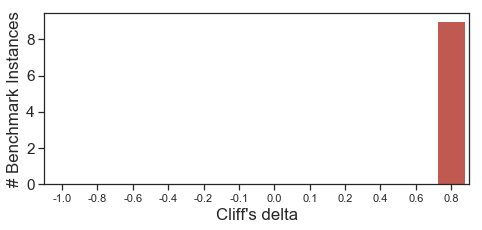

In [27]:
fork = df.query('Experiment == "FORK"')

plot_dsizes(fork, 'FORK')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]     0
(-0.8, -0.6]     2
(-0.6, -0.4]     4
(-0.4, -0.2]    14
(-0.2, -0.1]     4
(-0.1, 0.0]     19
(0.0, 0.1]       7
(0.1, 0.2]       6
(0.2, 0.4]       8
(0.4, 0.6]       5
(0.6, 0.8]       5
(0.8, 1.0]      13
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


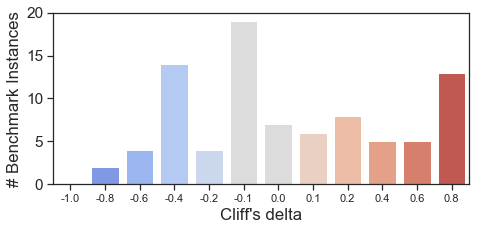

In [28]:
retu = df.query('Experiment == "RETU"')
plot_dsizes(retu, 'RETU')

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-1.   -0.8  -0.6  -0.4  -0.2  -0.14  0.    0.14  0.2   0.4   0.6   0.8
  1.  ]
(-1.0, -0.8]    0
(-0.8, -0.6]    0
(-0.6, -0.4]    1
(-0.4, -0.2]    1
(-0.2, -0.1]    0
(-0.1, 0.0]     1
(0.0, 0.1]      1
(0.1, 0.2]      2
(0.2, 0.4]      1
(0.4, 0.6]      0
(0.6, 0.8]      0
(0.8, 1.0]      0
Name: Cliffs Delta d norm, dtype: int64
['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0']


C:\Users\diego\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


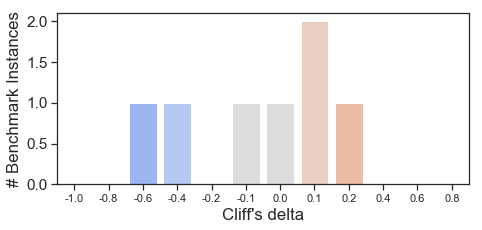

In [29]:
fina = df.query('Experiment == "FINA"')
plot_dsizes(fina, 'FINA')